In [47]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
import numpy as np
from torch.nn import KLDivLoss
from torchvision.io import read_video
from scipy.special import kl_div

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [48]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape

time_window = 5
patch_size = (35, 35)

pos_range = max(int(time_window / 2), 1) if time_window > 1 else 0
center_index = int(patch_size[0] / 2)

step_matrix = torch.ones(patch_size + (2,))

step_w = 2 / W
step_h = 2 / H

for k in range(0, patch_size[0]):
    for l in range(0, patch_size[1]):
        step_matrix[k, l, 0] = (l - center_index) * step_w
        step_matrix[k, l, 1] = (k - center_index) * step_h
        
n_bins = 32
hist_norm_p = float('inf')
v_max = 500

In [49]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

perfect_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=perfect_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))

N, T, K, C, Hp, Wp  = perfect_kpt_patches.shape

In [50]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))

bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))

In [51]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))

random_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=random_kpt_coordinates[0:1, ...],
                                        patch_size=(32, 32)).repeat((N, 1, 1, 1, 1, 1))

Apply Sobel filter to obtain gradients

In [52]:
from kornia.filters import sobel

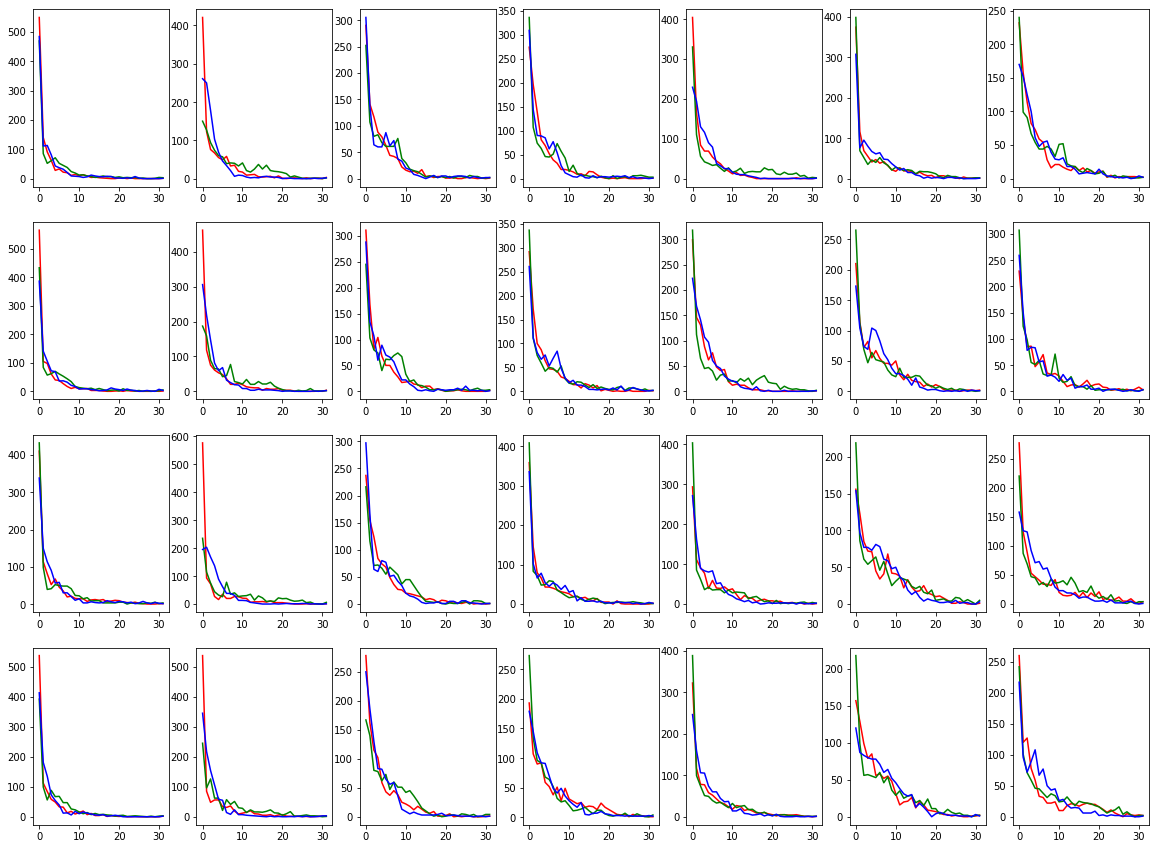

In [53]:
perfect_mag = sobel(perfect_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

perfect_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                perfect_mag_hists[n, t, k, c] = torch.histc(perfect_mag[n, t, k, c], bins=n_bins)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 2], color='blue')

tensor([[ 97.,  45.,  43.,  48., 105., 164.,  89.],
        [156., 114.,  74.,  74.,  85.,  54., 101.],
        [127., 150.,  66., 165.,  29.,  34.,  59.]])
tensor(89.4762)


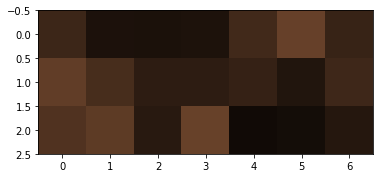

In [54]:
perfect_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        perfect_mag_dist[k, t] = torch.norm(perfect_mag_hists[0, t:t+1, k, :] - perfect_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(perfect_mag_dist.T)
        
plt.imshow(perfect_mag_dist.T.cpu().numpy(), cmap='copper', vmin=0, vmax=v_max)

print(perfect_mag_dist.mean())

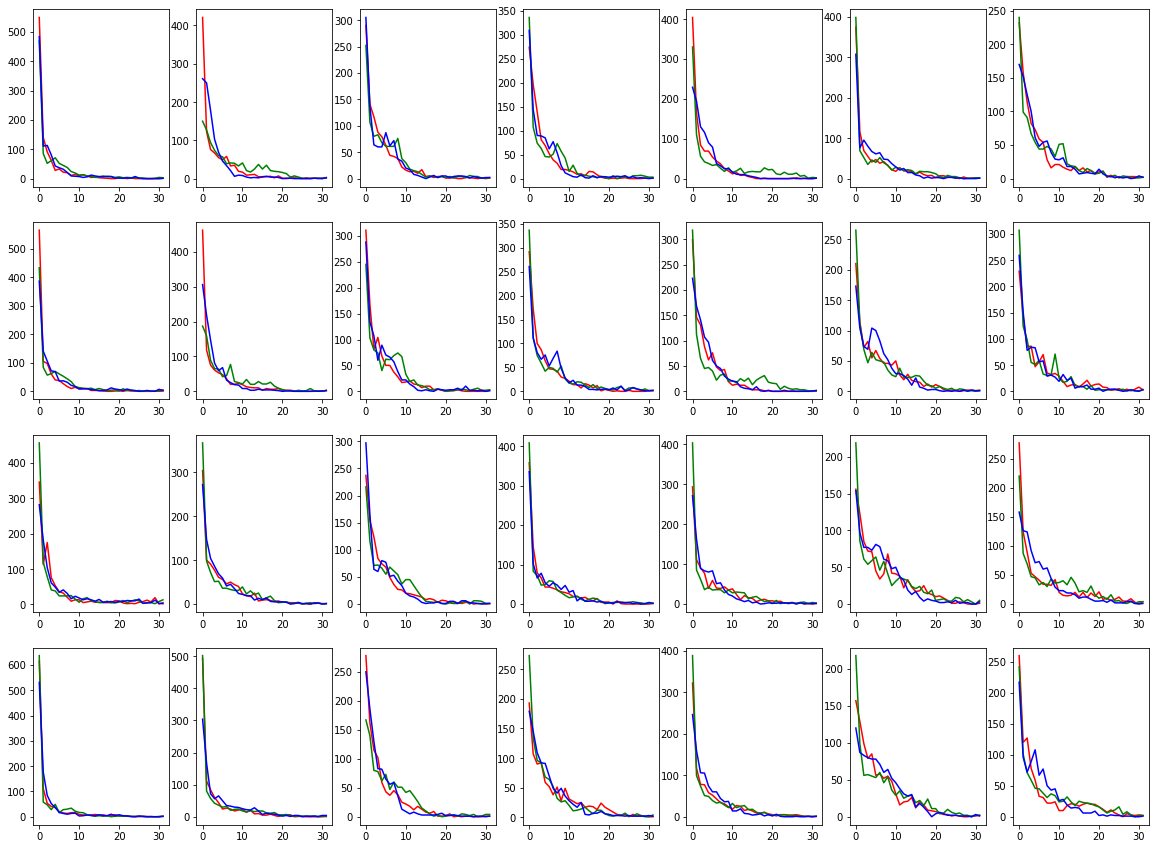

In [55]:
bad_mag = sobel(bad_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

bad_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                bad_mag_hists[n, t, k, c] = torch.histc(bad_mag[n, t, k, c], bins=n_bins)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 2], color='blue')

tensor([[ 97.,  45.,  43.,  48., 105., 164.,  89.],
        [220., 180.,  74.,  74.,  85.,  54., 101.],
        [269., 189.,  66., 165.,  29.,  34.,  59.]])
tensor(104.2857)


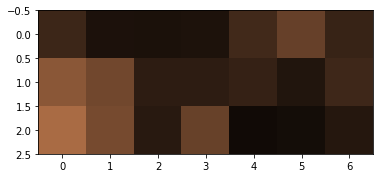

In [56]:
bad_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        bad_mag_dist[k, t] = torch.norm(bad_mag_hists[0, t:t+1, k, :] - bad_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(bad_mag_dist.T)
        
plt.imshow(bad_mag_dist.T.cpu().numpy(), cmap='copper', vmin=0, vmax=v_max)

print(bad_mag_dist.mean())

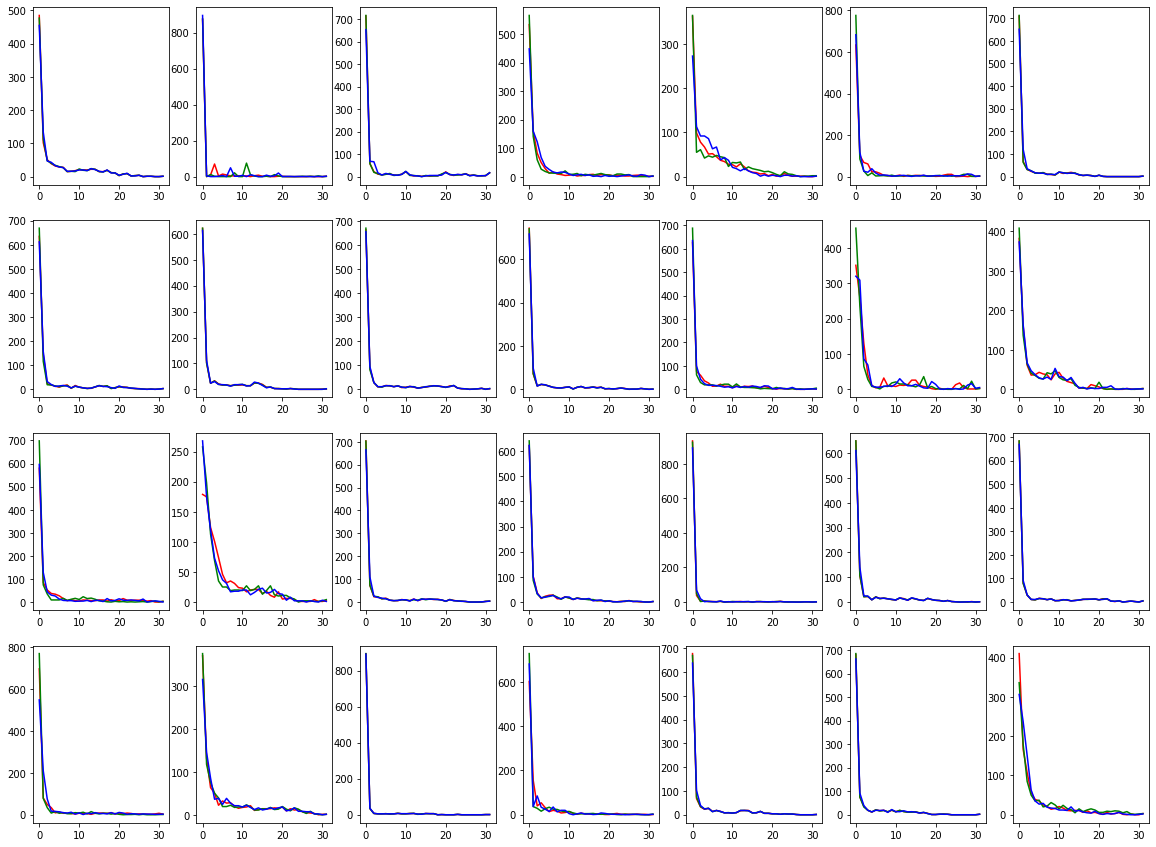

In [57]:
random_mag = sobel(random_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

random_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                random_mag_hists[n, t, k, c] = torch.histc(random_mag[n, t, k, c], bins=n_bins)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 2], color='blue')

tensor([[192., 283.,  51., 268., 362., 363., 327.],
        [ 59., 442.,  41., 121., 306., 299., 301.],
        [116., 191., 227.,  87., 255.,  51., 363.]])
tensor(224.0476)


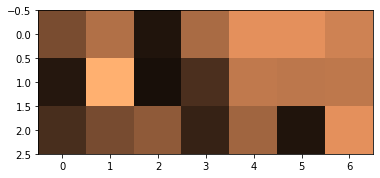

In [58]:
random_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        random_mag_dist[k, t] = torch.norm(random_mag_hists[0, t:t+1, k, :] - random_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(random_mag_dist.T)
        
plt.imshow(random_mag_dist.T.cpu().numpy(), cmap='copper', vmin=0, vmax=v_max)

print(random_mag_dist.mean())